In [1]:
import pandas as pd
import numpy as np
from plotnine import *

import time
from IPython.display import clear_output

## Review and Clean Data

In [2]:
df = pd.read_csv('data/survivor_boxscores.csv')

Scan through episodes to ensure decreasing number of contestants

In [3]:
review = False

if review == True:
    for szn in range(13,40):
        for epi in range(1,13):
            print('Season:',str(szn),', Episode:',str(epi))
            display(df.query('season == @szn & episode == @epi'))
            time.sleep(0.5)
            clear_output(wait=True)

Sort and remove nan / odd values

In [4]:
df = (df
      .sort_values(by = ['season','episode','player_name'], axis = 0)
      .fillna(0)
      .replace('0*', 0)
      .replace('#DIV0', 0)
      .replace('#DIV/0!', 0)
     )

Assign variable for contestants voted off next episode

In [5]:
grouped_df = df.groupby(['season','episode'])
df['voted_off_next'] = 0

for szn in np.unique(df['season']):
    
    episodes = df.loc[df['season'] == szn, 'episode'].unique()
    
    for epi in range(len(episodes)):
        
        if episodes[epi] == episodes.max():
            continue
        
        current_epi_df = grouped_df.get_group((szn,episodes[epi]))
        next_epi_df = grouped_df.get_group((szn,episodes[epi+1]))
        
        current_players = list(current_epi_df['player_name'])
        next_players = list(next_epi_df['player_name'])
        
        voted_off = [x for x in current_players if x not in next_players]
        
        for voted_off_player in voted_off:
            df.loc[
                (df['season'] == szn) & 
                (df['episode'] == episodes[epi-1]) & 
                (df['player_name'] == voted_off_player), 
                'voted_off_next'] = 1

Drop final two episodes of each season, as they dont have next episode predictions

In [6]:
for szn in np.unique(df['season']):
    no_episodes = df.loc[df['season'] == szn, 'episode'].max()
    df = df.drop(df[(df['season'] == szn) & 
                    ((df['episode'] == no_episodes) | 
                     (df['episode'] == no_episodes - 1))
                   ].index, axis = 0)
    df = df.reset_index(drop = True)

Rearrange columns

In [7]:
front_cols = ['season','episode','player_name','voted_off_next','total_days','exile_days',
              'votes_for_bootee','votes_against_player','total_votes','tribal_council_appearances']

for col in front_cols[::-1]:
    first_col = df.pop(col)
    df.insert(0, col, first_col)

Add cumulative sums per player per season

In [8]:
cumsums = df.columns.drop(['player_name','season','episode','voted_off_next'])

for variable in cumsums:
    df[variable] = df[variable].astype('float')
    df[str('cumsum_' + variable)] = df.groupby(['season','player_name'])[variable].cumsum()

In [9]:
df.query('player_name == "Richard"')

,season,episode,player_name,voted_off_next,total_days,exile_days,votes_for_bootee,votes_against_player,total_votes,tribal_council_appearances,...,cumsum_tribal_council_appearances,cumsum_challenge_wins,cumsum_challenge_appearances,cumsum_sit_outs,cumsum_reward_chl_win,cumsum_reward_chl_teammates,cumsum_reward_chl_win_perc,cumsum_immun_chl_win,cumsum_immun_chl_teammates,cumsum_immun_chl_win_perc
10,1,1,Richard,0,3.0,0.0,0.0,0.0,8.0,1.0,...,1.0,0.000000,0.125000,0.0,0.0,8.0,0.000000,0.0,0.0,0.000000
26,1,2,Richard,0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.142857,0.392857,0.0,0.0,15.0,0.000000,1.0,7.0,0.142857
40,1,3,Richard,0,3.0,0.0,1.0,0.0,7.0,1.0,...,2.0,0.285714,0.678571,0.0,1.0,22.0,0.142857,1.0,14.0,0.142857
54,1,4,Richard,0,3.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.619048,1.011905,0.0,2.0,28.0,0.309524,2.0,20.0,0.309524
66,1,5,Richard,0,3.0,0.0,1.0,0.0,6.0,1.0,...,3.0,0.619048,1.511905,0.0,2.0,31.0,0.309524,2.0,26.0,0.309524
77,1,6,Richard,0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.869048,2.095238,0.0,2.0,34.0,0.309524,3.0,30.0,0.559524
87,1,7,Richard,0,3.0,0.0,1.0,1.0,10.0,1.0,...,4.0,0.869048,3.095238,0.0,2.0,35.0,0.309524,3.0,30.0,0.559524
96,1,8,Richard,0,3.0,0.0,1.0,0.0,9.0,1.0,...,5.0,0.869048,5.095238,0.0,2.0,36.0,0.309524,3.0,31.0,0.559524
104,1,9,Richard,0,3.0,0.0,1.0,3.0,8.0,1.0,...,6.0,0.869048,7.095238,0.0,2.0,37.0,0.309524,3.0,32.0,0.559524
111,1,10,Richard,0,3.0,0.0,1.0,0.0,7.0,1.0,...,7.0,1.869048,9.095238,0.0,2.0,38.0,0.309524,4.0,33.0,1.559524


For EDA, group df by player and season to show season totals for all features

In [10]:
grouped_df = df.groupby(['season','player_name']).sum()

Write to CSV

In [11]:
df.to_csv('data/survivor_boxscores_clean.csv.', index = False)
grouped_df.to_csv('data/survivor_boxscores_clean_grouped.csv.', index = False)

## EDA and Visualizations

In [19]:
(df
 .drop(list(df.filter(like = 'cumsum')), axis = 1)
 .describe()
)

,season,episode,voted_off_next,total_days,exile_days,votes_for_bootee,votes_against_player,total_votes,tribal_council_appearances,challenge_wins,challenge_appearances,sit_outs,reward_chl_win,reward_chl_teammates,reward_chl_win_perc,immun_chl_win,immun_chl_teammates,immun_chl_win_perc
count,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.000000,6604.00000,6604.000000,6604.000000,6604.000000
mean,23.285887,5.589188,0.079497,2.681859,0.094942,0.397335,0.618413,5.061326,0.613113,0.134476,0.581642,0.089945,0.281364,3.701847,0.06572,0.261205,3.527105,0.066788
std,12.302009,3.346117,0.270534,0.579718,0.451741,0.507612,1.607400,4.570483,0.517526,0.241486,0.564500,0.291370,0.440960,3.087593,0.14770,0.429344,3.256005,0.175542
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,13.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000
50%,24.000000,5.000000,0.000000,3.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.309524,0.000000,0.000000,4.000000,0.00000,0.000000,3.000000,0.000000
75%,34.000000,8.000000,0.000000,3.000000,0.000000,1.000000,0.000000,9.000000,1.000000,0.166667,1.000000,0.000000,1.000000,6.000000,0.12500,0.500000,6.000000,0.100000
max,43.000000,16.000000,1.000000,4.000000,4.000000,2.000000,12.000000,21.000000,2.000000,2.333333,3.000000,2.000000,1.000000,10.000000,1.00000,1.000000,10.000000,1.000000


In [13]:
(grouped_df
 .drop(list(grouped_df.filter(like = 'cumsum')), axis = 1)
 .describe()
)

,episode,voted_off_next,total_days,exile_days,votes_for_bootee,votes_against_player,total_votes,tribal_council_appearances,challenge_wins,challenge_appearances,sit_outs,reward_chl_win,reward_chl_teammates,reward_chl_win_perc,immun_chl_win,immun_chl_teammates,immun_chl_win_perc
count,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,46.428931,0.660377,22.277987,0.788679,3.300629,5.137107,42.044025,5.093082,1.117083,4.831656,0.747170,2.337264,30.750943,0.545931,2.169811,29.299371,0.554799
std,30.744800,0.473879,10.323731,2.979463,2.652680,3.158702,25.555823,2.955401,1.027946,3.581735,1.129065,1.953628,17.894974,0.595152,1.699320,14.870166,0.661897
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,14.000000,0.000000,1.000000,3.000000,18.000000,2.000000,0.334722,1.242460,0.000000,1.000000,16.000000,0.125000,1.000000,18.500000,0.125000
50%,55.000000,1.000000,25.000000,0.000000,3.000000,5.000000,40.000000,5.000000,0.852778,4.717460,0.000000,2.000000,31.000000,0.392857,2.000000,30.000000,0.325000
75%,78.000000,1.000000,32.000000,0.000000,5.000000,7.000000,64.000000,8.000000,1.647024,7.974802,1.000000,3.500000,44.000000,0.759325,3.000000,39.000000,0.646627
max,136.000000,1.000000,36.000000,28.000000,11.000000,19.000000,108.000000,13.000000,8.336905,12.095238,7.000000,9.000000,68.000000,4.000000,8.000000,63.000000,4.645635


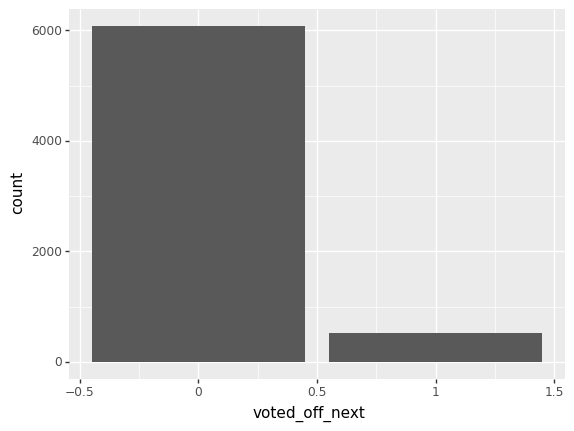

<ggplot: (176893822001)>

In [24]:
(ggplot(df) +
 aes(x = 'voted_off_next') +
 geom_bar()
)

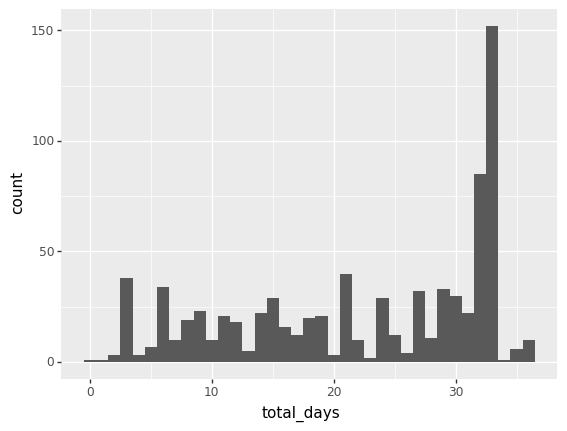

<ggplot: (176865188509)>

In [14]:
(ggplot(grouped_df) +
 aes(x = 'total_days') +
 geom_histogram(binwidth = 1)
)

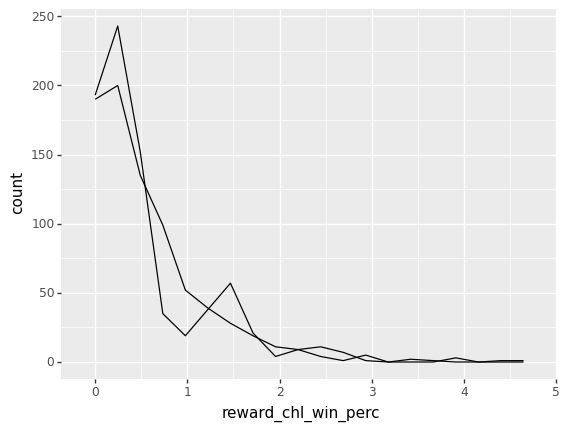

<ggplot: (176892652273)>

In [15]:
(ggplot(grouped_df) +
 geom_freqpoly(aes(x = 'reward_chl_win_perc'), bins = 20) +
 geom_freqpoly(aes(x = 'immun_chl_win_perc'), bins = 20)
)

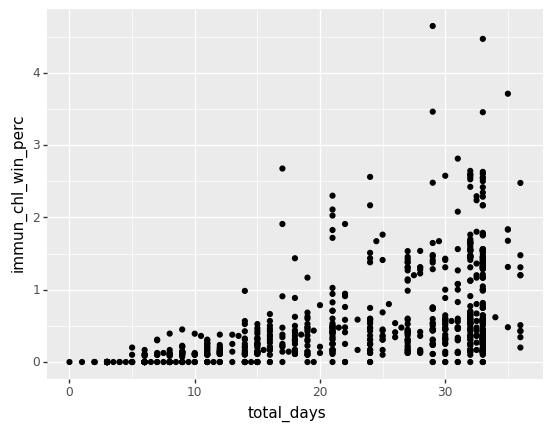

<ggplot: (176893837529)>

In [16]:
(ggplot(grouped_df) +
 aes(x = 'total_days', y = 'immun_chl_win_perc') +
 geom_point()
)

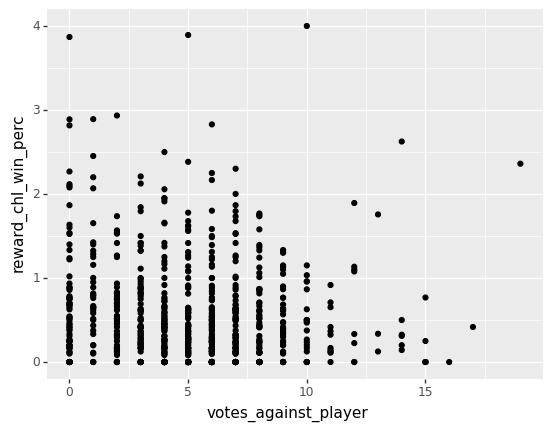

<ggplot: (176893795717)>

In [17]:
(ggplot(grouped_df) +
 aes(x = 'votes_against_player', y = 'reward_chl_win_perc') +
 geom_point()
)

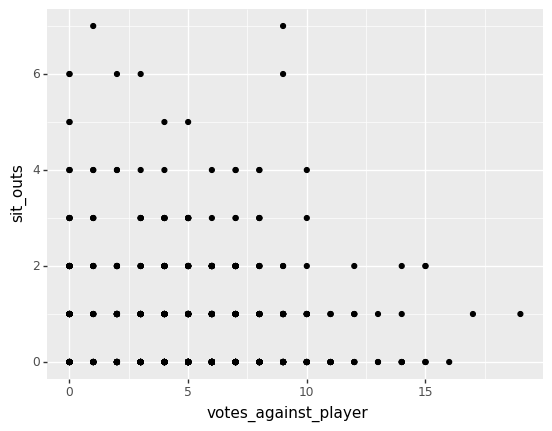

<ggplot: (176893862957)>

In [18]:
(ggplot(grouped_df) +
 aes(x = 'votes_against_player', y = 'sit_outs') +
 geom_point()
)